#Install needed libraries

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/"
%cd {path}
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python setup.py install

Cloning into 'vnquant'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 341 (delta 65), reused 89 (delta 53), pack-reused 237
Receiving objects: 100% (341/341), 1.05 MiB | 5.64 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/vnquant
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/

In [ ]:
%cd ..
!rm -rf vnquant
!ls

/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!pip freeze | grep vnquant

vnquant==0.1.1


In [ ]:
import vnquant
vnquant.__version__

'0.1.1'

In [ ]:
!pip install plotly
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.9 MB/s eta 0:00:00


In [ ]:
import vnquant.data as dt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

#We choose 10 codes from biggest companies on stock exchange in Vietnam

In [ ]:
stock_symbols = ['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']
print(stock_symbols)

['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']


#Prepare the dataset

In [ ]:
stock_data = {}

for symbol in stock_symbols:
  df = dt.DataLoader(symbols=symbol,
                     start="2014-01-01",
                     end="2024-01-01",
                     minimal=True,
                     data_source="VND")
  stock_data[symbol] = df.download()



In [ ]:
stock_data[stock_symbols[1]]

Attributes,high,low,open,close,avg,volume
Symbols,VCB,VCB,VCB,VCB,VCB,VCB
date,,,,,,
2014-01-02,26.9,26.6,26.9,26.7,26.74,333900.0
2014-01-03,27.3,26.7,26.7,27.2,27.07,813360.0
2014-01-06,27.4,27.0,27.3,27.1,27.17,375890.0
2014-01-07,27.9,27.4,27.5,27.7,27.68,2372530.0
2014-01-08,28.1,27.6,27.8,28.1,27.86,1474370.0
...,...,...,...,...,...,...
2023-12-25,81.8,80.7,80.9,81.8,81.45,1480000.0
2023-12-26,82.8,82.0,82.0,82.8,82.47,1113200.0


In [ ]:
def reconstruct_data(list_price):
  week = []
  combine = []
  i = 0
  while (i < len(list_price)):
    if (len(week) != 4):
      week.append(np.round(np.mean(list_price[i:i+7]), 2))
      i = i + 7
    else:
      combine.append(week)
      week = []

  return combine

##VIC

In [ ]:
close = stock_data[stock_symbols[0]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_vic = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[0]}'), ('close_week2', f'{stock_symbols[0]}'),
                                  ('close_week3', f'{stock_symbols[0]}'), ('close_week4', f'{stock_symbols[0]}')], dtype = np.dtype(np.float64))
df_vic.head()

,"(close_week1, VIC)","(close_week2, VIC)","(close_week3, VIC)","(close_week4, VIC)"
0,70.43,72.93,75.93,77.43
1,77.71,74.64,77.14,75.50
2,72.36,66.79,65.93,63.43
3,66.07,67.21,65.21,64.07
4,64.14,69.21,69.86,72.21


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_vic[('close_total4week', f'{stock_symbols[0]}')] = mean_close[:len(df_vic)]

In [ ]:
df_vic

,"(close_week1, VIC)","(close_week2, VIC)","(close_week3, VIC)","(close_week4, VIC)","(close_total4week, VIC)"
0,70.43,72.93,75.93,77.43,74.18
1,77.71,74.64,77.14,75.50,76.25
2,72.36,66.79,65.93,63.43,67.12
3,66.07,67.21,65.21,64.07,65.64
4,64.14,69.21,69.86,72.21,68.86
...,...,...,...,...,...
84,53.06,52.00,50.80,52.00,51.96
85,52.04,62.04,71.27,64.44,62.45
86,61.00,55.26,47.25,45.59,52.28
87,44.86,42.80,41.59,44.69,43.48


##VCB

In [ ]:
close = stock_data[stock_symbols[1]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_vcb = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[1]}'), ('close_week2', f'{stock_symbols[1]}'),
                                  ('close_week3', f'{stock_symbols[1]}'), ('close_week4', f'{stock_symbols[1]}')], dtype = np.dtype(np.float64))
df_vcb.head()

,"(close_week1, VCB)","(close_week2, VCB)","(close_week3, VCB)","(close_week4, VCB)"
0,27.56,28.26,28.56,28.87
1,29.71,30.20,30.86,31.00
2,31.29,29.70,28.63,25.37
3,26.87,28.60,28.79,27.53
4,26.16,25.97,25.96,25.76


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_vcb[('close_total4week', f'{stock_symbols[1]}')] = mean_close[:len(df_vcb)]

In [ ]:
df_vcb

,"(close_week1, VCB)","(close_week2, VCB)","(close_week3, VCB)","(close_week4, VCB)","(close_total4week, VCB)"
0,27.56,28.26,28.56,28.87,28.31
1,29.71,30.20,30.86,31.00,30.44
2,31.29,29.70,28.63,25.37,28.75
3,26.87,28.60,28.79,27.53,27.95
4,26.16,25.97,25.96,25.76,25.96
...,...,...,...,...,...
84,102.17,100.47,101.91,104.93,102.37
85,96.00,90.73,89.27,87.59,90.90
86,89.43,88.97,87.99,85.67,88.01
87,85.93,85.21,88.54,86.67,86.59


##VNM

In [ ]:
close = stock_data[stock_symbols[2]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_vnm = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[2]}'), ('close_week2', f'{stock_symbols[2]}'),
                                  ('close_week3', f'{stock_symbols[2]}'), ('close_week4', f'{stock_symbols[2]}')], dtype = np.dtype(np.float64))
df_vnm.head()

,"(close_week1, VNM)","(close_week2, VNM)","(close_week3, VNM)","(close_week4, VNM)"
0,136.00,138.71,140.57,139.57
1,139.43,139.57,145.86,141.57
2,144.29,141.00,139.14,127.29
3,123.14,123.43,123.29,121.57
4,122.43,128.14,132.00,135.86


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_vnm[('close_total4week', f'{stock_symbols[2]}')] = mean_close[:len(df_vnm)]

In [ ]:
df_vnm

,"(close_week1, VNM)","(close_week2, VNM)","(close_week3, VNM)","(close_week4, VNM)","(close_total4week, VNM)"
0,136.00,138.71,140.57,139.57,138.71
1,139.43,139.57,145.86,141.57,141.61
2,144.29,141.00,139.14,127.29,137.93
3,123.14,123.43,123.29,121.57,122.86
4,122.43,128.14,132.00,135.86,129.61
...,...,...,...,...,...
84,66.39,70.09,71.06,72.83,70.09
85,75.39,74.31,73.26,74.86,74.45
86,79.24,79.20,76.40,74.14,77.25
87,74.43,69.20,70.36,69.84,70.96


##GAS

In [ ]:
close = stock_data[stock_symbols[3]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_gas = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[3]}'), ('close_week2', f'{stock_symbols[3]}'),
                                  ('close_week3', f'{stock_symbols[3]}'), ('close_week4', f'{stock_symbols[3]}')], dtype = np.dtype(np.float64))
df_gas.head()

,"(close_week1, GAS)","(close_week2, GAS)","(close_week3, GAS)","(close_week4, GAS)"
0,67.36,75.07,76.50,81.36
1,83.71,83.00,84.93,83.00
2,87.36,92.14,95.43,93.79
3,90.36,95.36,103.14,105.29
4,109.29,110.57,110.71,112.43


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_gas[('close_total4week', f'{stock_symbols[3]}')] = mean_close[:len(df_gas)]

In [ ]:
df_gas

,"(close_week1, GAS)","(close_week2, GAS)","(close_week3, GAS)","(close_week4, GAS)","(close_total4week, GAS)"
0,67.36,75.07,76.50,81.36,75.07
1,83.71,83.00,84.93,83.00,83.66
2,87.36,92.14,95.43,93.79,92.18
3,90.36,95.36,103.14,105.29,98.54
4,109.29,110.57,110.71,112.43,110.75
...,...,...,...,...,...
84,95.46,95.16,95.61,98.74,96.24
85,99.17,100.59,100.33,101.17,100.31
86,100.79,107.41,92.40,86.11,96.68
87,84.97,79.30,78.51,79.37,80.54


##HVN

In [ ]:
close = stock_data[stock_symbols[4]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_hvn = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[4]}'), ('close_week2', f'{stock_symbols[4]}'),
                                  ('close_week3', f'{stock_symbols[4]}'), ('close_week4', f'{stock_symbols[4]}')], dtype = np.dtype(np.float64))
df_hvn.head()

,"(close_week1, HVN)","(close_week2, HVN)","(close_week3, HVN)","(close_week4, HVN)"
0,43.69,40.24,38.47,41.14
1,38.44,33.83,31.19,30.46
2,28.30,25.79,26.33,26.19
3,28.20,26.83,26.77,26.97
4,26.73,26.66,26.47,26.27


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_hvn[('close_total4week', f'{stock_symbols[4]}')] = mean_close[:len(df_hvn)]

In [ ]:
df_hvn

,"(close_week1, HVN)","(close_week2, HVN)","(close_week3, HVN)","(close_week4, HVN)","(close_total4week, HVN)"
0,43.69,40.24,38.47,41.14,40.89
1,38.44,33.83,31.19,30.46,33.48
2,28.30,25.79,26.33,26.19,26.65
3,28.20,26.83,26.77,26.97,27.19
4,26.73,26.66,26.47,26.27,26.53
...,...,...,...,...,...
57,13.46,13.51,14.29,13.20,13.61
58,12.99,12.97,13.24,13.04,13.06
59,12.75,13.24,12.67,11.81,12.62
60,11.64,11.34,10.64,10.79,11.10


##MWG

In [ ]:
close = stock_data[stock_symbols[5]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_mwg = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[5]}'), ('close_week2', f'{stock_symbols[5]}'),
                                  ('close_week3', f'{stock_symbols[5]}'), ('close_week4', f'{stock_symbols[5]}')], dtype = np.dtype(np.float64))
df_mwg.head()

,"(close_week1, MWG)","(close_week2, MWG)","(close_week3, MWG)","(close_week4, MWG)"
0,97.43,106.86,106.43,134.57
1,137.57,143.00,157.14,168.86
2,148.71,109.86,106.71,102.00
3,100.57,93.71,95.71,99.57
4,104.86,107.86,116.86,120.43


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_mwg[('close_total4week', f'{stock_symbols[5]}')] = mean_close[:len(df_mwg)]

In [ ]:
df_mwg

,"(close_week1, MWG)","(close_week2, MWG)","(close_week3, MWG)","(close_week4, MWG)","(close_total4week, MWG)"
0,97.43,106.86,106.43,134.57,111.32
1,137.57,143.00,157.14,168.86,151.64
2,148.71,109.86,106.71,102.00,116.82
3,100.57,93.71,95.71,99.57,97.39
4,104.86,107.86,116.86,120.43,112.50
...,...,...,...,...,...
79,38.68,41.52,42.11,43.49,41.45
80,44.98,48.89,53.64,52.73,50.06
81,53.06,50.59,54.56,56.11,53.58
82,52.34,48.89,47.11,42.67,47.75


##FPT

In [ ]:
close = stock_data[stock_symbols[6]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_fpt = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[6]}'), ('close_week2', f'{stock_symbols[6]}'),
                                  ('close_week3', f'{stock_symbols[6]}'), ('close_week4', f'{stock_symbols[6]}')], dtype = np.dtype(np.float64))
df_fpt.head()

,"(close_week1, FPT)","(close_week2, FPT)","(close_week3, FPT)","(close_week4, FPT)"
0,47.87,50.76,54.64,56.79
1,61.07,62.93,69.21,69.79
2,69.07,69.14,66.93,48.13
3,44.47,45.67,45.29,46.47
4,46.63,49.26,50.60,50.80


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_fpt[('close_total4week', f'{stock_symbols[6]}')] = mean_close[:len(df_fpt)]

In [ ]:
df_fpt

,"(close_week1, FPT)","(close_week2, FPT)","(close_week3, FPT)","(close_week4, FPT)","(close_total4week, FPT)"
0,47.87,50.76,54.64,56.79,52.51
1,61.07,62.93,69.21,69.79,65.75
2,69.07,69.14,66.93,48.13,63.32
3,44.47,45.67,45.29,46.47,45.48
4,46.63,49.26,50.60,50.80,49.32
...,...,...,...,...,...
84,84.74,86.17,78.34,77.99,81.81
85,82.81,83.83,83.91,89.59,85.04
86,97.43,97.73,94.63,93.44,95.81
87,94.91,89.37,87.69,92.06,91.01


##HPG

In [ ]:
close = stock_data[stock_symbols[7]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_hpg = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[7]}'), ('close_week2', f'{stock_symbols[7]}'),
                                  ('close_week3', f'{stock_symbols[7]}'), ('close_week4', f'{stock_symbols[7]}')], dtype = np.dtype(np.float64))
df_hpg.head()

,"(close_week1, HPG)","(close_week2, HPG)","(close_week3, HPG)","(close_week4, HPG)"
0,42.29,48.33,47.66,48.44
1,49.13,48.71,50.84,52.36
2,54.64,54.21,50.77,45.81
3,48.60,51.14,49.79,52.29
4,53.64,55.14,57.29,56.14


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_hpg[('close_total4week', f'{stock_symbols[7]}')] = mean_close[:len(df_hpg)]

In [ ]:
df_hpg

,"(close_week1, HPG)","(close_week2, HPG)","(close_week3, HPG)","(close_week4, HPG)","(close_total4week, HPG)"
0,42.29,48.33,47.66,48.44,46.68
1,49.13,48.71,50.84,52.36,50.26
2,54.64,54.21,50.77,45.81,51.36
3,48.60,51.14,49.79,52.29,50.45
4,53.64,55.14,57.29,56.14,55.55
...,...,...,...,...,...
84,23.53,25.69,26.98,27.38,25.89
85,28.31,27.39,27.67,26.30,27.42
86,28.14,28.10,26.76,25.37,27.09
87,25.04,23.65,25.11,26.87,25.17


##MSN

In [ ]:
close = stock_data[stock_symbols[8]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_msn = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[8]}'), ('close_week2', f'{stock_symbols[8]}'),
                                  ('close_week3', f'{stock_symbols[8]}'), ('close_week4', f'{stock_symbols[8]}')], dtype = np.dtype(np.float64))
df_msn.head()

,"(close_week1, MSN)","(close_week2, MSN)","(close_week3, MSN)","(close_week4, MSN)"
0,83.36,91.29,93.21,93.07
1,98.00,97.57,104.07,99.07
2,94.64,94.29,94.29,90.50
3,91.00,96.00,98.00,95.07
4,91.71,92.36,91.79,90.29


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_msn[('close_total4week', f'{stock_symbols[8]}')] = mean_close[:len(df_msn)]

In [ ]:
df_msn

,"(close_week1, MSN)","(close_week2, MSN)","(close_week3, MSN)","(close_week4, MSN)","(close_total4week, MSN)"
0,83.36,91.29,93.21,93.07,90.23
1,98.00,97.57,104.07,99.07,99.68
2,94.64,94.29,94.29,90.50,93.43
3,91.00,96.00,98.00,95.07,95.02
4,91.71,92.36,91.79,90.29,91.54
...,...,...,...,...,...
84,76.61,76.66,76.44,80.66,77.59
85,84.66,87.10,82.14,79.14,83.26
86,81.24,79.51,75.19,73.87,77.45
87,70.99,63.59,62.01,63.57,65.04


##SAB

In [ ]:
close = stock_data[stock_symbols[9]]['close'].values

In [ ]:
reconstruct_close = reconstruct_data(close)

In [ ]:
df_sab = pd.DataFrame(reconstruct_close, columns =[('close_week1', f'{stock_symbols[9]}'), ('close_week2', f'{stock_symbols[9]}'),
                                  ('close_week3', f'{stock_symbols[9]}'), ('close_week4', f'{stock_symbols[9]}')], dtype = np.dtype(np.float64))
df_sab.head()

,"(close_week1, SAB)","(close_week2, SAB)","(close_week3, SAB)","(close_week4, SAB)"
0,163.00,207.07,197.51,206.43
1,220.13,216.73,214.94,224.86
2,220.47,209.67,200.86,203.61
3,203.64,200.03,197.60,191.16
4,190.23,191.59,200.59,206.90


In [ ]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [ ]:
df_sab[('close_total4week', f'{stock_symbols[9]}')] = mean_close[:len(df_sab)]

In [ ]:
df_sab

,"(close_week1, SAB)","(close_week2, SAB)","(close_week3, SAB)","(close_week4, SAB)","(close_total4week, SAB)"
0,163.00,207.07,197.51,206.43,193.50
1,220.13,216.73,214.94,224.86,219.16
2,220.47,209.67,200.86,203.61,208.65
3,203.64,200.03,197.60,191.16,198.11
4,190.23,191.59,200.59,206.90,197.32
...,...,...,...,...,...
58,158.84,155.06,152.77,152.53,154.80
59,156.87,159.81,158.49,153.20,157.09
60,159.26,118.76,76.70,70.53,106.31
61,69.27,67.67,61.64,63.16,65.44


#All Company

In [ ]:
df_all = {}

In [ ]:
df_all[stock_symbols[0]] = df_vic
df_all[stock_symbols[1]] = df_vcb
df_all[stock_symbols[2]] = df_vnm
df_all[stock_symbols[3]] = df_gas
df_all[stock_symbols[4]] = df_hvn
df_all[stock_symbols[5]] = df_mwg
df_all[stock_symbols[6]] = df_fpt
df_all[stock_symbols[7]] = df_hpg
df_all[stock_symbols[8]] = df_msn
df_all[stock_symbols[9]] = df_sab

In [ ]:
for i in range(len(stock_symbols)):
  df_all[stock_symbols[i]] = df_all[stock_symbols[i]].ewm(alpha=0.65).mean()

df_all[stock_symbols[2]]

,"(close_week1, VNM)","(close_week2, VNM)","(close_week3, VNM)","(close_week4, VNM)","(close_total4week, VNM)"
0,136.000000,138.710000,140.570000,139.570000,138.710000
1,138.540741,139.347037,144.488519,141.051481,140.858148
2,142.445161,140.469593,140.856248,131.705823,138.869593
3,129.705634,129.225120,129.264234,125.017167,128.304820
4,124.951502,128.516068,131.051871,132.102220,129.157666
...,...,...,...,...,...
84,68.259964,70.424983,70.480968,71.303389,70.116383
85,72.894487,72.950244,72.287339,73.615186,72.933234
86,77.019071,77.012585,74.960569,73.956315,75.739132
87,75.336175,71.934405,71.970199,71.280710,72.632696


In [ ]:
def closediff(x, y):
  res = []

  for i in range(len(x)):
    res.append(((y[i]-x[i]) / x[i])*100)

  return res

In [ ]:
for i in range(len(stock_symbols)):
  close_week1 = df_all[stock_symbols[i]][('close_week1', f'{stock_symbols[i]}')].values
  close_week2 = df_all[stock_symbols[i]][('close_week2', f'{stock_symbols[i]}')].values
  close_week3 = df_all[stock_symbols[i]][('close_week3', f'{stock_symbols[i]}')].values
  close_week4 = df_all[stock_symbols[i]][('close_week4', f'{stock_symbols[i]}')].values

  df_all[stock_symbols[i]][('closediff_week2_1', f'{stock_symbols[i]}')] = closediff(close_week1, close_week2)
  df_all[stock_symbols[i]][('closediff_week3_1', f'{stock_symbols[i]}')] = closediff(close_week1, close_week3)
  df_all[stock_symbols[i]][('closediff_week4_1', f'{stock_symbols[i]}')] = closediff(close_week1, close_week4)
  df_all[stock_symbols[i]][('closediff_week3_2', f'{stock_symbols[i]}')] = closediff(close_week2, close_week3)
  df_all[stock_symbols[i]][('closediff_week4_2', f'{stock_symbols[i]}')] = closediff(close_week2, close_week4)
  df_all[stock_symbols[i]][('closediff_week4_3', f'{stock_symbols[i]}')] = closediff(close_week3, close_week4)

In [ ]:
df_all[stock_symbols[0]]

,"(close_week1, VIC)","(close_week2, VIC)","(close_week3, VIC)","(close_week4, VIC)","(close_total4week, VIC)","(closediff_week2_1, VIC)","(closediff_week3_1, VIC)","(closediff_week4_1, VIC)","(closediff_week3_2, VIC)","(closediff_week4_2, VIC)","(closediff_week4_3, VIC)"
0,70.430000,72.930000,75.930000,77.430000,74.180000,3.549624,7.809172,9.938946,4.113534,6.170300,1.975504
1,75.822593,74.196667,76.826296,76.000370,75.713333,-2.144382,1.323753,0.234465,3.544134,2.430977,-1.075056
2,73.471087,69.166672,69.426435,67.463616,69.877453,-5.858651,-5.505093,-8.176645,0.375560,-2.462249,-2.827192
3,68.587090,67.875459,66.643998,65.224160,67.081147,-1.037558,-2.833028,-4.903153,-1.814295,-3.906123,-2.130482
4,65.681219,68.747491,68.745437,69.788931,68.243506,4.668414,4.665287,6.254013,-0.002988,1.514877,1.517911
...,...,...,...,...,...,...,...,...,...,...,...
84,52.655544,52.625601,51.504168,52.236176,52.250608,-0.056867,-2.186619,-0.796437,-2.130964,-0.739991,1.421260
85,52.255441,58.744960,64.351959,60.168662,58.880213,12.418841,23.148821,15.143344,9.544646,2.423529,-6.500652
86,57.939404,56.479736,53.235686,50.692532,54.590074,-2.519301,-8.118341,-12.507675,-5.743742,-10.246515,-4.777160
87,49.437791,47.587908,45.665990,46.790886,47.368526,-3.741842,-7.629389,-5.354012,-4.038668,-1.674841,2.463313


In [ ]:
def total_closediff(a, b, c, d, e, f):
  res = []

  for i in range(len(a)):
    res.append(((a[i]+b[i]+c[i]+d[i]+e[i]+f[i])/6))

  return res

In [ ]:
for i in range(len(stock_symbols)):
  df_all[stock_symbols[i]][('total_closediff', f'{stock_symbols[i]}')] = total_closediff(df_all[stock_symbols[i]][('closediff_week2_1', f'{stock_symbols[i]}')], df_all[stock_symbols[i]][('closediff_week3_1', f'{stock_symbols[i]}')],
                                                                     df_all[stock_symbols[i]][('closediff_week4_1', f'{stock_symbols[i]}')], df_all[stock_symbols[i]][('closediff_week3_2', f'{stock_symbols[i]}')],
                                                                     df_all[stock_symbols[i]][('closediff_week4_2', f'{stock_symbols[i]}')], df_all[stock_symbols[i]][('closediff_week4_3', f'{stock_symbols[i]}')])

In [ ]:
df_all[stock_symbols[1]]

,"(close_week1, VCB)","(close_week2, VCB)","(close_week3, VCB)","(close_week4, VCB)","(close_total4week, VCB)","(closediff_week2_1, VCB)","(closediff_week3_1, VCB)","(closediff_week4_1, VCB)","(closediff_week3_2, VCB)","(closediff_week4_2, VCB)","(closediff_week4_3, VCB)","(total_closediff, VCB)"
0,27.560000,28.260000,28.560000,28.870000,28.310000,2.539913,3.628447,4.753266,1.061571,2.158528,1.085434,2.537860
1,29.152593,29.697037,30.263704,30.447778,29.887778,1.867568,3.811363,4.442779,1.908159,2.527999,0.608234,2.527684
2,30.604143,29.699049,29.154228,26.999372,29.115093,-2.957421,-4.737643,-11.778702,-1.834475,-9.090114,-7.391229,-6.298264
3,28.139972,28.973784,28.913873,27.349535,28.346245,2.963087,2.750183,-2.808948,-0.206776,-5.605926,-5.410337,-1.386453
4,26.846195,27.011015,26.983718,26.310882,26.786996,0.613943,0.512262,-1.994000,-0.101061,-2.592030,-2.493489,-1.009062
...,...,...,...,...,...,...,...,...,...,...,...,...
84,98.200197,97.604373,98.357439,101.516549,98.920337,-0.606744,0.160123,3.377133,0.771549,4.008197,3.211867,1.820354
85,96.770069,93.136031,92.450604,92.464292,93.707118,-3.755333,-4.463638,-4.449492,-0.735942,-0.721245,0.014806,-2.351807
86,91.999024,90.428111,89.551211,88.048002,90.003991,-1.707533,-2.660694,-4.294635,-0.969720,-2.632045,-1.678603,-2.323872
87,88.054158,87.036339,88.893924,87.152301,87.784897,-1.155902,0.953692,-1.024208,2.134264,0.133234,-1.959215,-0.153022


In [ ]:
for i in range(len(stock_symbols)):
  df_all[stock_symbols[i]].replace(0, np.nan, inplace=True)
  df_all[stock_symbols[i]] = df_all[stock_symbols[i]].dropna()

In [ ]:
for i in range(len(stock_symbols)):
  df_all[stock_symbols[i]]['trend', str(stock_symbols[i])] = (df_all[stock_symbols[i]]['total_closediff', f'{stock_symbols[i]}'].iloc[:] > 0).astype(int)

In [ ]:
df_all[stock_symbols[1]]

,"(close_week1, VCB)","(close_week2, VCB)","(close_week3, VCB)","(close_week4, VCB)","(close_total4week, VCB)","(closediff_week2_1, VCB)","(closediff_week3_1, VCB)","(closediff_week4_1, VCB)","(closediff_week3_2, VCB)","(closediff_week4_2, VCB)","(closediff_week4_3, VCB)","(total_closediff, VCB)","(trend, VCB)"
0,27.560000,28.260000,28.560000,28.870000,28.310000,2.539913,3.628447,4.753266,1.061571,2.158528,1.085434,2.537860,1
1,29.152593,29.697037,30.263704,30.447778,29.887778,1.867568,3.811363,4.442779,1.908159,2.527999,0.608234,2.527684,1
2,30.604143,29.699049,29.154228,26.999372,29.115093,-2.957421,-4.737643,-11.778702,-1.834475,-9.090114,-7.391229,-6.298264,0
3,28.139972,28.973784,28.913873,27.349535,28.346245,2.963087,2.750183,-2.808948,-0.206776,-5.605926,-5.410337,-1.386453,0
4,26.846195,27.011015,26.983718,26.310882,26.786996,0.613943,0.512262,-1.994000,-0.101061,-2.592030,-2.493489,-1.009062,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,98.200197,97.604373,98.357439,101.516549,98.920337,-0.606744,0.160123,3.377133,0.771549,4.008197,3.211867,1.820354,1
85,96.770069,93.136031,92.450604,92.464292,93.707118,-3.755333,-4.463638,-4.449492,-0.735942,-0.721245,0.014806,-2.351807,0
86,91.999024,90.428111,89.551211,88.048002,90.003991,-1.707533,-2.660694,-4.294635,-0.969720,-2.632045,-1.678603,-2.323872,0
87,88.054158,87.036339,88.893924,87.152301,87.784897,-1.155902,0.953692,-1.024208,2.134264,0.133234,-1.959215,-0.153022,0


#Visualizing Data

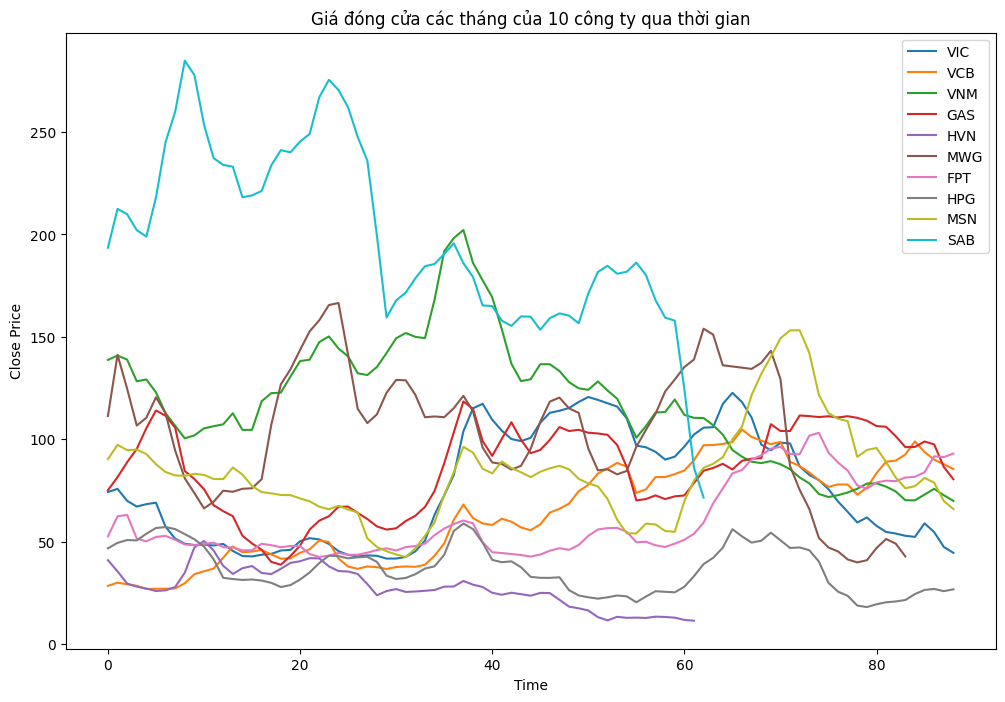

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Giá đóng cửa các tháng của 10 công ty qua thời gian")

for symbol in stock_symbols:
  plt.plot(df_all[symbol].index, df_all[symbol][('close_total4week',symbol)], label=symbol)

plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#ARIMA Model

#VIC

In [ ]:
vic_total = df_all[stock_symbols[0]][('close_total4week', stock_symbols[0])]
trend_data = df_all[stock_symbols[0]][('trend', stock_symbols[0])]
d = ndiffs(vic_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = vic_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

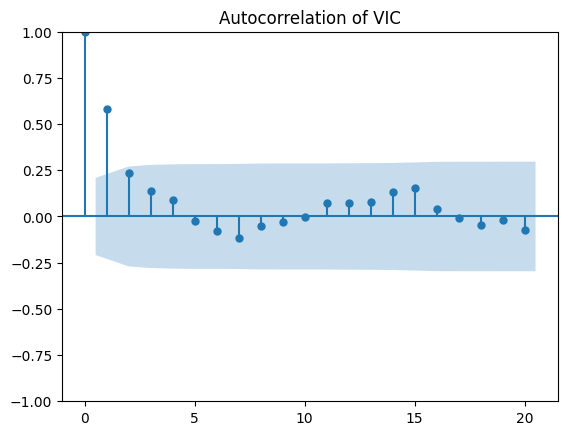

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[0])
plt.show()

<Figure size 1800x600 with 0 Axes>

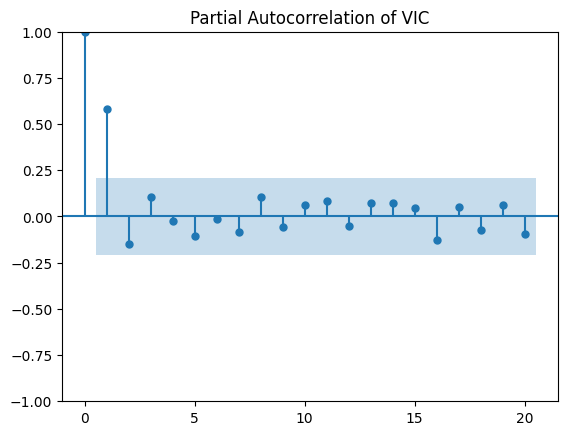

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[0])
plt.show()

In [ ]:
train_len = int(len(vic_total)*0.8)
train_data = vic_total[:train_len]
test_data = vic_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  71
Test data:  18
Trend test data: 18


In [ ]:
model = ARIMA(train_data, order=(3,1,5))
result = model.fit()
print(result.summary())

                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'VIC')   No. Observations:                   71
Model:                          ARIMA(3, 1, 5)   Log Likelihood                -199.976
Date:                         Tue, 12 Mar 2024   AIC                            417.951
Time:                                 14:23:30   BIC                            438.188
Sample:                                      0   HQIC                           425.990
                                          - 71                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4770      0.359      4.120      0.000       0.774       2.180
ar.L2         -1.2149      0.460     -2.639      0.008     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


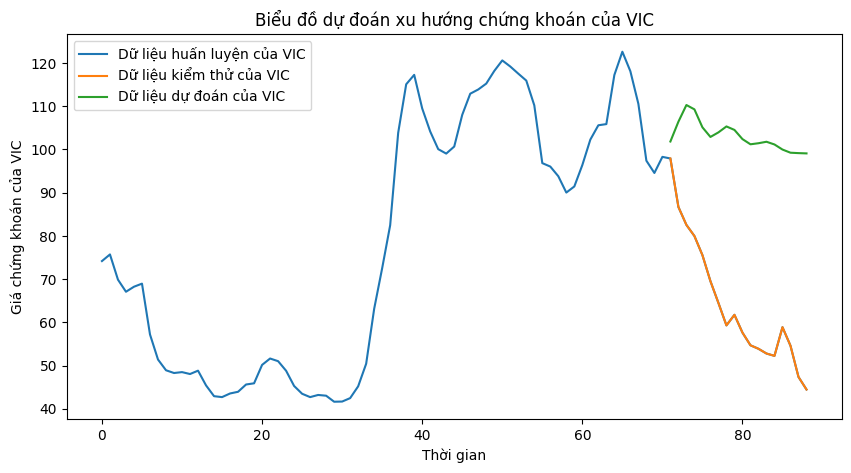

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(vic_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[0])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[0])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[0])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[0])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[0])
plt.legend()
plt.show()

In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.61


#VCB

In [ ]:
vcb_total = df_all[stock_symbols[1]][('close_total4week', stock_symbols[1])]
trend_data = df_all[stock_symbols[1]][('trend', stock_symbols[1])]
d = ndiffs(vcb_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = vcb_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

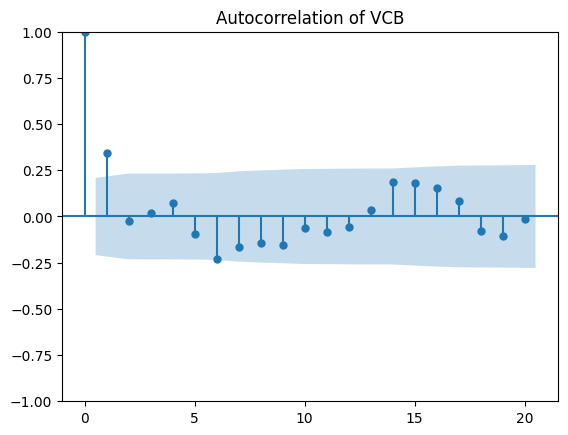

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[1])
plt.show()

<Figure size 1800x600 with 0 Axes>

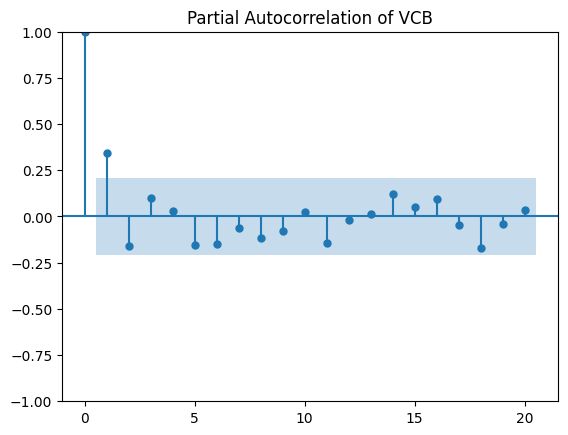

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[1])
plt.show()

In [ ]:
train_len = int(len(vcb_total)*0.8)
train_data = vcb_total[:train_len]
test_data = vcb_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  71
Test data:  18
Trend test data: 18


In [ ]:
model = ARIMA(train_data, order=(3,1,7))
result = model.fit()
print(result.summary())

                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'VCB')   No. Observations:                   71
Model:                          ARIMA(3, 1, 7)   Log Likelihood                -182.583
Date:                         Tue, 12 Mar 2024   AIC                            387.167
Time:                                 16:45:42   BIC                            411.900
Sample:                                      0   HQIC                           396.991
                                          - 71                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5978      0.215      2.782      0.005       0.177       1.019
ar.L2          0.4696      0.213      2.209      0.027     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


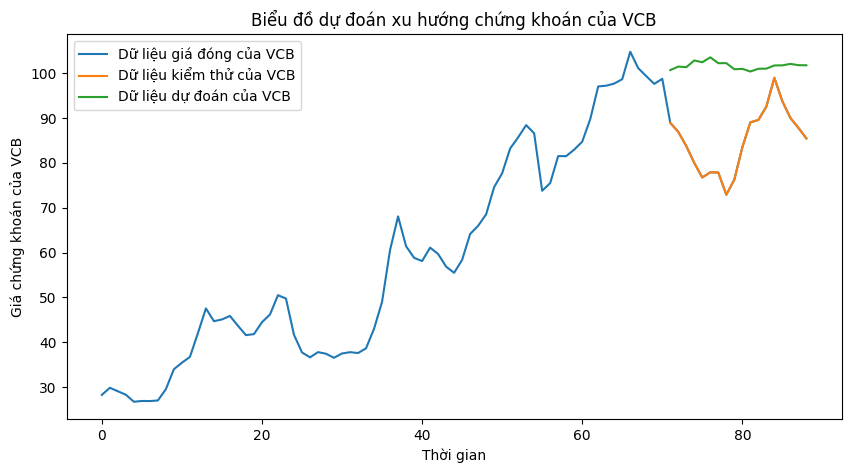

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(vcb_total, label="Dữ liệu giá đóng của %s" % stock_symbols[1])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[1])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[1])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[1])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[1])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.56


#VNM

In [ ]:
vnm_total = df_all[stock_symbols[2]][('close_total4week', stock_symbols[2])]
trend_data = df_all[stock_symbols[2]][('trend', stock_symbols[2])]
d = ndiffs(vnm_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = vnm_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

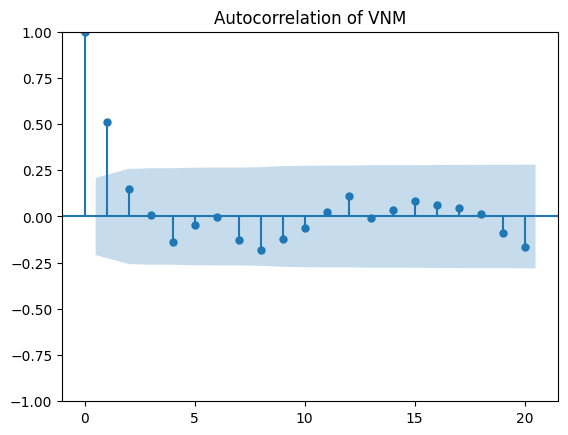

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[2])
plt.show()

<Figure size 1800x600 with 0 Axes>

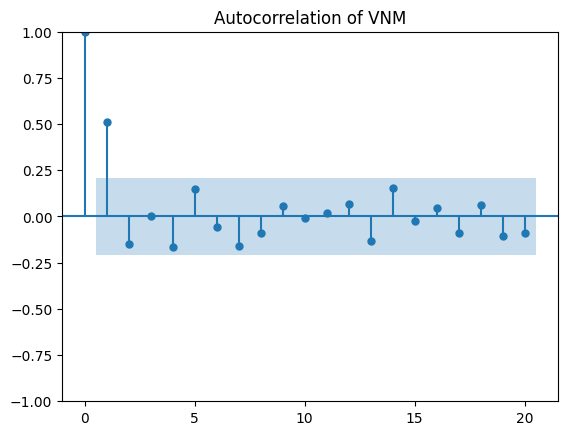

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[2])
plt.show()

In [ ]:
train_len = int(len(vnm_total)*0.8)
train_data = vnm_total[:train_len]
test_data = vnm_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  71
Test data:  18
Trend test data: 18


In [ ]:
model = ARIMA(train_data, order=(7,1,2))
result = model.fit()
print(result.summary())

                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'VNM')   No. Observations:                   71
Model:                          ARIMA(7, 1, 2)   Log Likelihood                -223.421
Date:                         Tue, 12 Mar 2024   AIC                            466.842
Time:                                 15:12:52   BIC                            489.327
Sample:                                      0   HQIC                           475.773
                                          - 71                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1111      0.929      1.197      0.231      -0.709       2.931
ar.L2         -0.7736      1.242     -0.623      0.533     

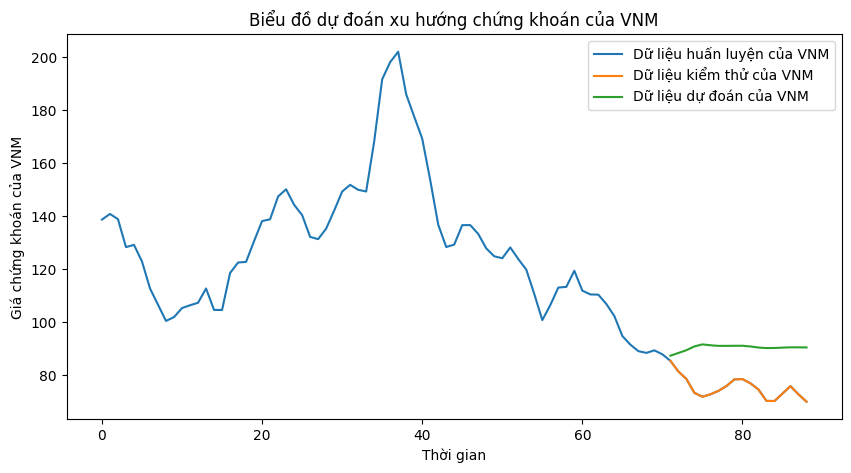

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(vnm_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[2])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[2])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[2])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[2])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[2])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.67


#GAS

In [ ]:
gas_total = df_all[stock_symbols[3]][('close_total4week', stock_symbols[3])]
trend_data = df_all[stock_symbols[3]][('trend', stock_symbols[3])]
d = ndiffs(gas_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = gas_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

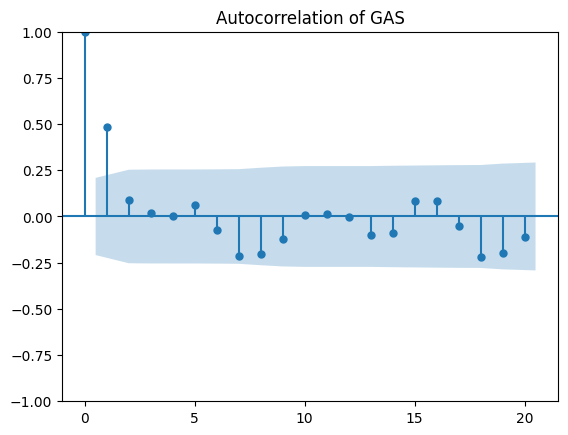

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[3])
plt.show()

<Figure size 1800x600 with 0 Axes>

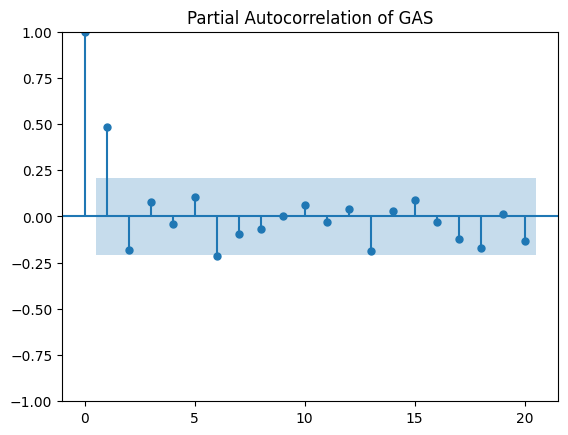

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[3])
plt.show()

In [ ]:
train_len = int(len(gas_total)*0.8)
train_data = gas_total[:train_len]
test_data = gas_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  71
Test data:  18
Trend test data: 18


In [ ]:
model = ARIMA(train_data, order=(2,1,15))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'GAS')   No. Observations:                   71
Model:                         ARIMA(2, 1, 15)   Log Likelihood                -217.034
Date:                         Tue, 12 Mar 2024   AIC                            470.067
Time:                                 16:32:22   BIC                            510.540
Sample:                                      0   HQIC                           486.143
                                          - 71                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5089      1.033      0.493      0.622      -1.515       2.533
ar.L2         -0.0945      0.550     -0.172      0.864     

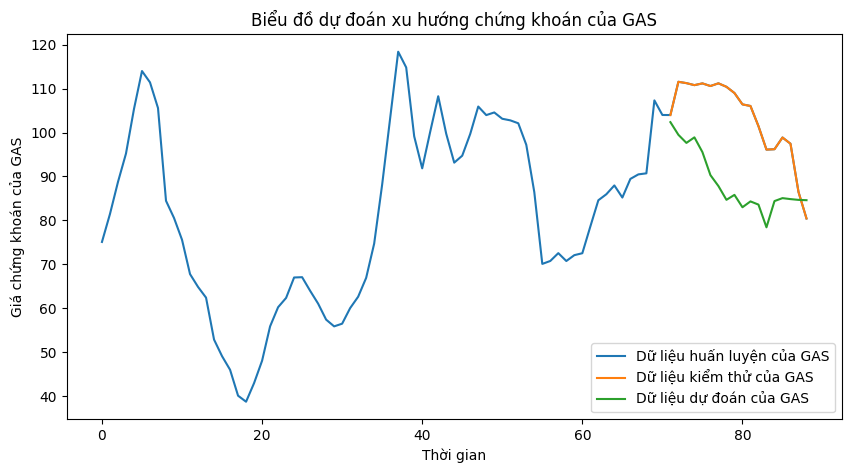

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(gas_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[3])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[3])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[3])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[3])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[3])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.61


#HVN

In [ ]:
hvn_total = df_all[stock_symbols[4]][('close_total4week', stock_symbols[4])]
trend_data = df_all[stock_symbols[4]][('trend', stock_symbols[4])]
d = ndiffs(hvn_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = hvn_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

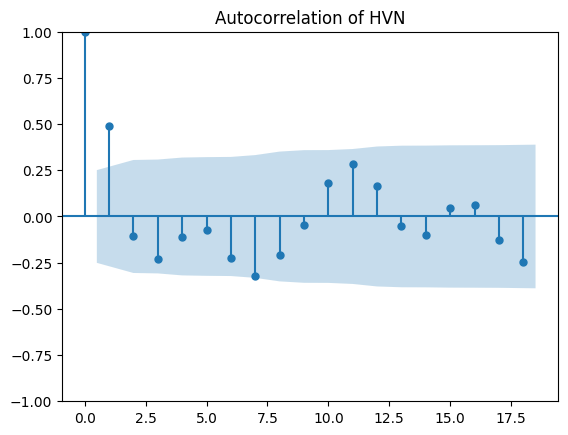

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[4])
plt.show()

<Figure size 1700x600 with 0 Axes>

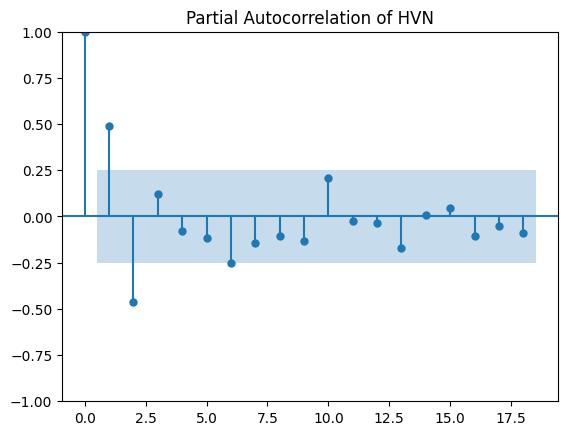

In [ ]:
plt.figure(figsize = (17,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[4])
plt.show()

In [ ]:
train_len = int(len(hvn_total)*0.8)
train_data = hvn_total[:train_len]
test_data = hvn_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  49
Test data:  13
Trend test data:  13


In [ ]:
model = ARIMA(train_data, order=(6,1,11))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'HVN')   No. Observations:                   49
Model:                         ARIMA(6, 1, 11)   Log Likelihood                -104.475
Date:                         Tue, 12 Mar 2024   AIC                            244.949
Time:                                 15:58:10   BIC                            278.631
Sample:                                      0   HQIC                           257.678
                                          - 49                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7538      1.295      0.582      0.560      -1.784       3.291
ar.L2         -0.4106      2.217     -0.185      0.853     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


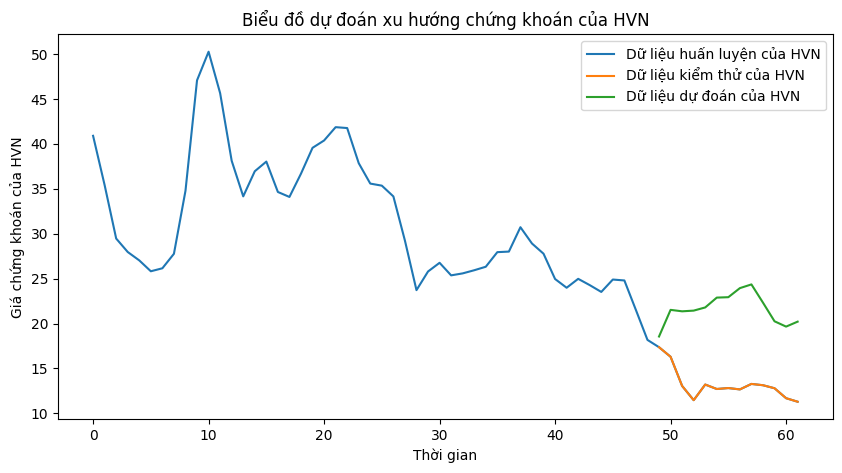

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(hvn_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[4])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[4])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[4])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[4])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[4])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.62


#MWG

In [ ]:
mwg_total = df_all[stock_symbols[5]][('close_total4week', stock_symbols[5])]
trend_data = df_all[stock_symbols[5]][('trend', stock_symbols[5])]
d = ndiffs(mwg_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = mwg_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

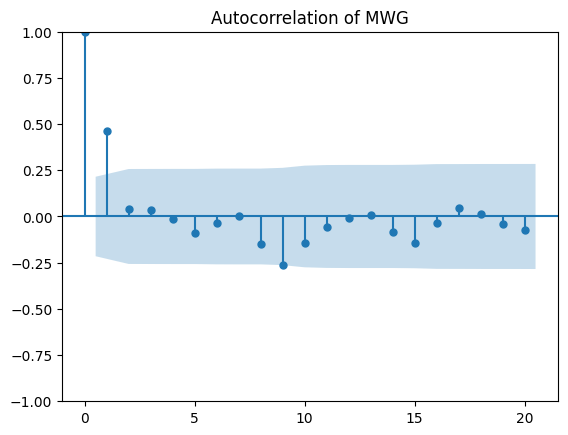

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[5])
plt.show()

<Figure size 1700x600 with 0 Axes>

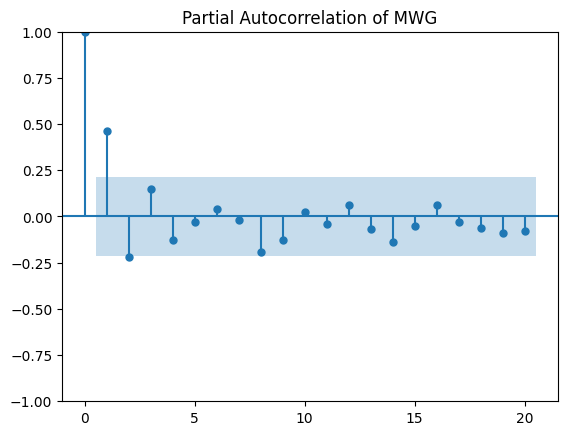

In [ ]:
plt.figure(figsize = (17,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[5])
plt.show()

In [ ]:
train_len = int(len(mwg_total)*0.8)
train_data = mwg_total[:train_len]
test_data = mwg_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  67
Test data:  17
Trend test data:  17


In [ ]:
model = ARIMA(train_data, order=(9,1,8))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'MWG')   No. Observations:                   67
Model:                          ARIMA(9, 1, 8)   Log Likelihood                -226.229
Date:                         Tue, 12 Mar 2024   AIC                            488.458
Time:                                 15:51:40   BIC                            527.872
Sample:                                      0   HQIC                           504.033
                                          - 67                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1710      0.474      0.361      0.718      -0.759       1.101
ar.L2         -0.0605      0.442     -0.137      0.891     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


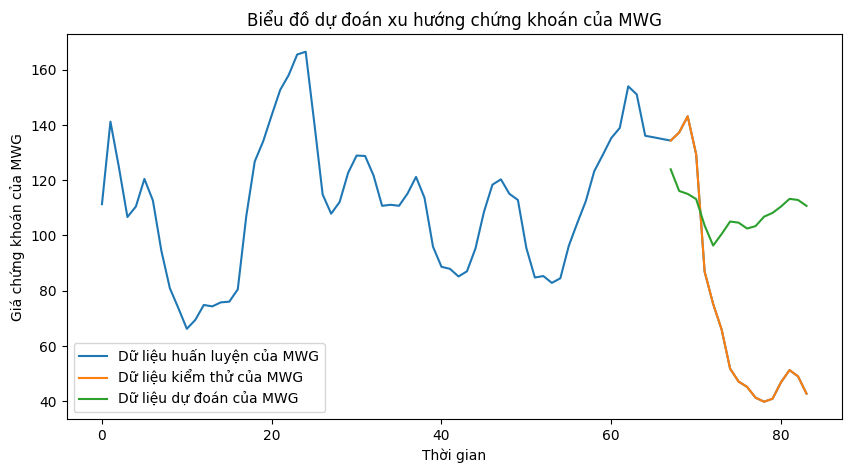

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(mwg_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[5])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[5])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[5])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[5])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[5])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.65


#FPT

In [ ]:
fpt_total = df_all[stock_symbols[6]][('close_total4week',stock_symbols[6])]
trend_data = df_all[stock_symbols[6]][('trend',stock_symbols[6])]
d = ndiffs(fpt_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = fpt_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

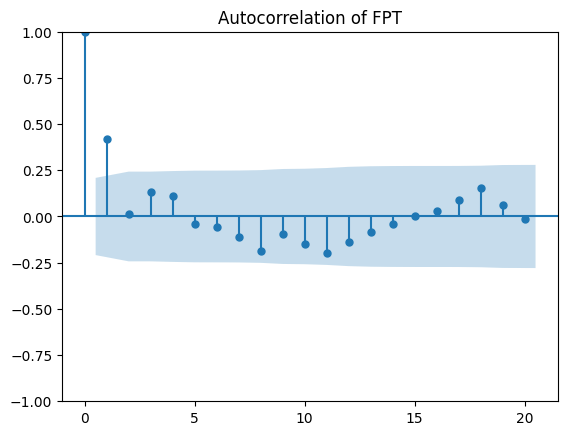

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[6])
plt.show()

<Figure size 1800x600 with 0 Axes>

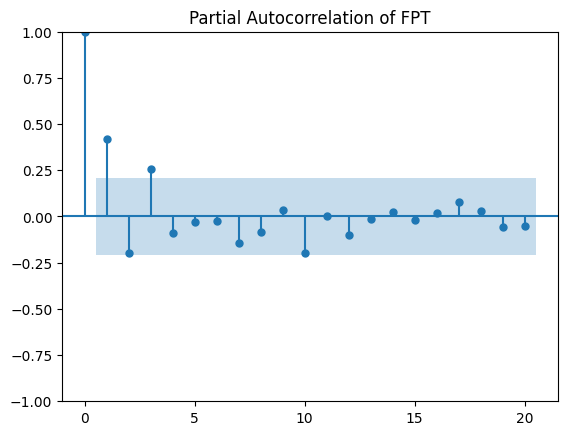

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[6])
plt.show()

In [ ]:
train_len = int(len(fpt_total)*0.8)
train_data = fpt_total[:train_len]
test_data = fpt_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  71
Test data:  18
Trend test data:  18


In [ ]:
model = ARIMA(train_data, order=(10,1,7))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'FPT')   No. Observations:                   71
Model:                         ARIMA(10, 1, 7)   Log Likelihood                -160.904
Date:                         Tue, 12 Mar 2024   AIC                            357.808
Time:                                 16:06:50   BIC                            398.281
Sample:                                      0   HQIC                           373.884
                                          - 71                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1370      4.326      0.032      0.975      -8.343       8.617
ar.L2          0.0149      3.724      0.004      0.997     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


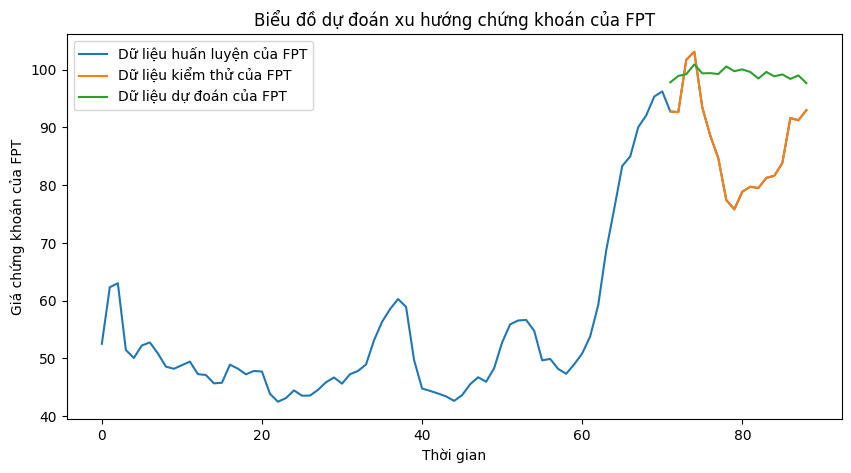

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(fpt_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[6])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[6])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[6])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[6])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[6])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.72


#HPG

In [ ]:
hpg_total = df_all[stock_symbols[7]][('close_total4week', stock_symbols[7])]
trend_data = df_all[stock_symbols[7]][('trend', stock_symbols[7])]
d = ndiffs(hpg_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 0


<Figure size 1800x600 with 0 Axes>

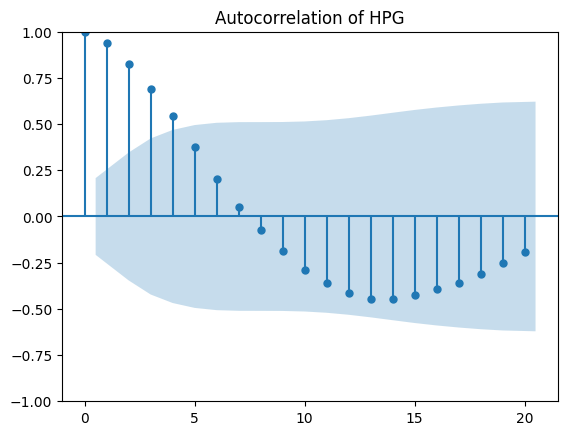

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(hpg_total)
plt.title("Autocorrelation of %s" % stock_symbols[7])
plt.show()

<Figure size 1800x600 with 0 Axes>

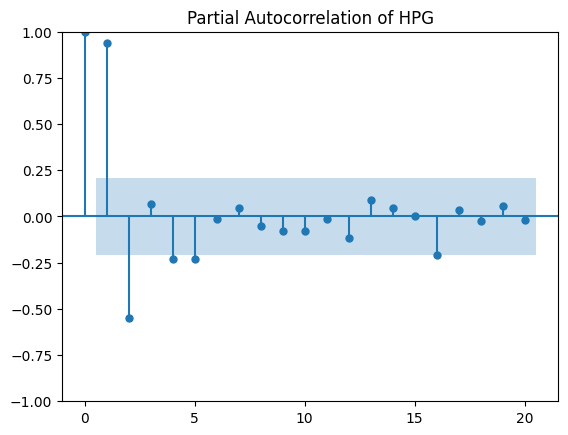

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(hpg_total)
plt.title("Partial Autocorrelation of %s" % stock_symbols[7])
plt.show()

In [ ]:
train_len = int(len(hpg_total)*0.8)
train_data = hpg_total[:train_len]
test_data = hpg_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  71
Test data:  18
Trend test data:  18


In [ ]:
model = ARIMA(train_data, order=(12,0,10))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'HPG')   No. Observations:                   71
Model:                        ARIMA(12, 0, 10)   Log Likelihood                -163.173
Date:                         Tue, 12 Mar 2024   AIC                            374.345
Time:                                 16:11:54   BIC                            428.649
Sample:                                      0   HQIC                           395.940
                                          - 71                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.8111      2.044     18.501      0.000      33.806      41.817
ar.L1         -0.1584      1.415     -0.112      0.911     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


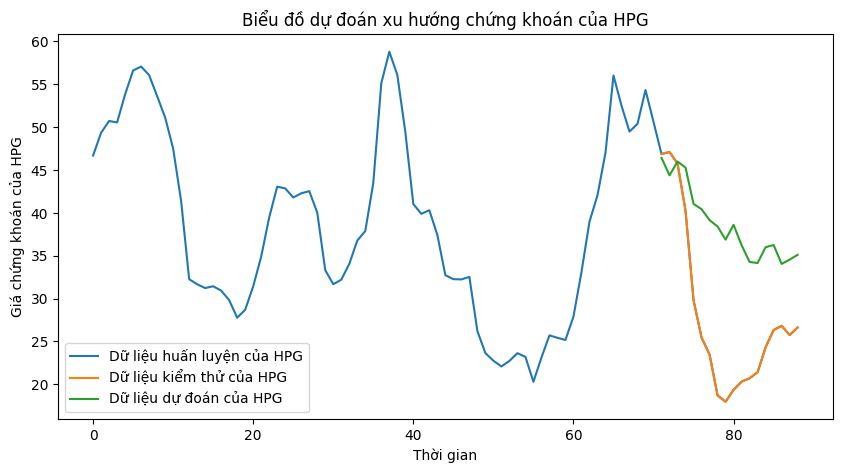

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(hpg_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[7])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[7])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[7])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[7])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[7])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.67


#MSN

In [ ]:
msn_total = df_all[stock_symbols[8]][('close_total4week', stock_symbols[8])]
trend_data = df_all[stock_symbols[8]][('trend', stock_symbols[8])]
d = ndiffs(msn_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 2


In [ ]:
close_diff = msn_total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

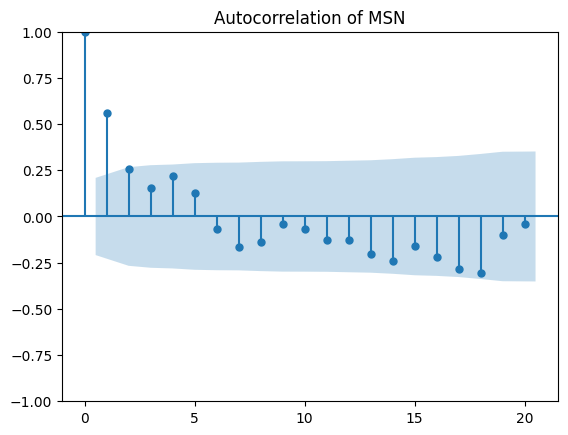

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[8])
plt.show()

<Figure size 1800x600 with 0 Axes>

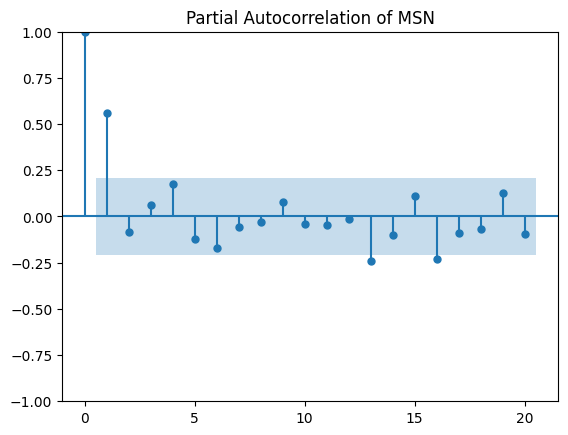

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[8])
plt.show()

In [ ]:
train_len = int(len(msn_total)*0.8)
train_data = msn_total[:train_len]
test_data = msn_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  71
Test data:  18
Trend test data:  18


In [ ]:
model = ARIMA(train_data, order=(4,1,7))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'MSN')   No. Observations:                   71
Model:                          ARIMA(4, 1, 7)   Log Likelihood                -198.018
Date:                         Tue, 12 Mar 2024   AIC                            420.035
Time:                                 16:20:08   BIC                            447.017
Sample:                                      0   HQIC                           430.753
                                          - 71                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9010      3.109      0.290      0.772      -5.192       6.994
ar.L2          0.4452      2.832      0.157      0.875     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


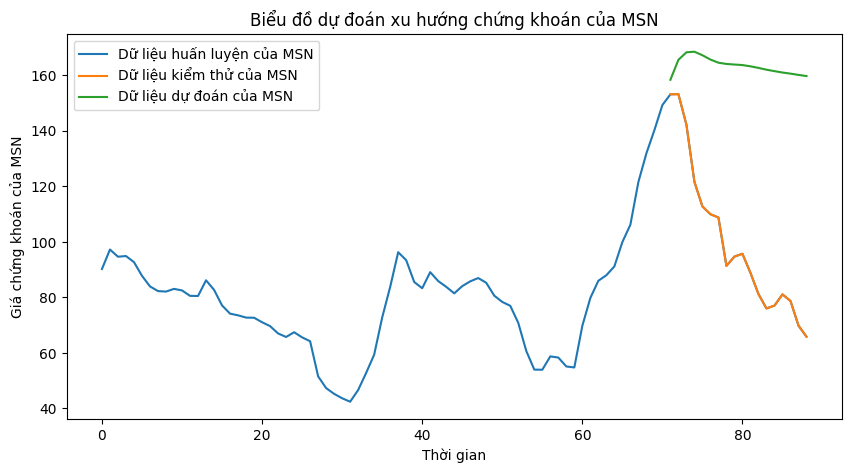

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(msn_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[8])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[8])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[8])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[8])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[8])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.61


#SAB

In [ ]:
sab_total = df_all[stock_symbols[9]][('close_total4week',stock_symbols[9])]
trend_data = df_all[stock_symbols[9]][('trend',stock_symbols[9])]
d = ndiffs(sab_total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 0


In [ ]:
close_diff = sab_total.dropna()

<Figure size 1800x600 with 0 Axes>

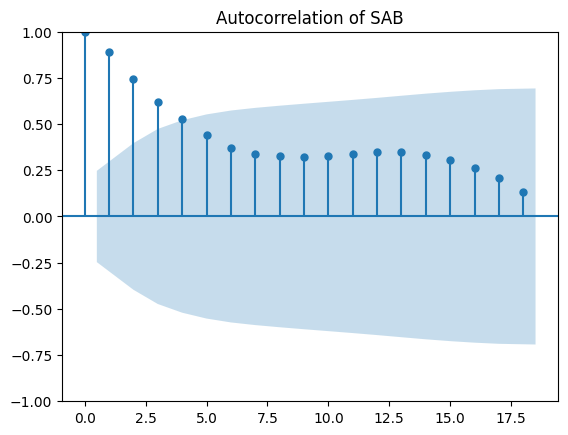

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[9])
plt.show()

<Figure size 1800x600 with 0 Axes>

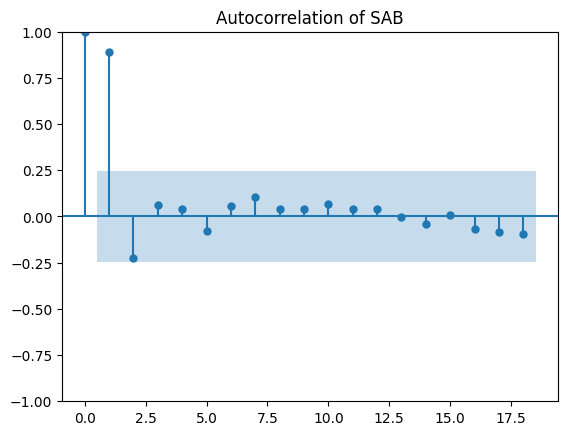

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Autocorrelation of %s" % stock_symbols[9])
plt.show()

In [ ]:
train_len = int(len(sab_total)*0.8)
train_data = sab_total[:train_len]
test_data = sab_total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: '), len(trend_test)


Train data:  50
Test data:  13
Trend test data: 


(None, 13)

In [ ]:
model = ARIMA(train_data, order=(5,0,6))
result = model.fit()
print(result.summary())

                                    SARIMAX Results                                    
Dep. Variable:     ('close_total4week', 'SAB')   No. Observations:                   50
Model:                          ARIMA(5, 0, 6)   Log Likelihood                -186.804
Date:                         Tue, 12 Mar 2024   AIC                            399.607
Time:                                 16:28:27   BIC                            424.463
Sample:                                      0   HQIC                           409.073
                                          - 50                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        208.5762     39.238      5.316      0.000     131.671     285.481
ar.L1          1.5137      0.434      3.489      0.000     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


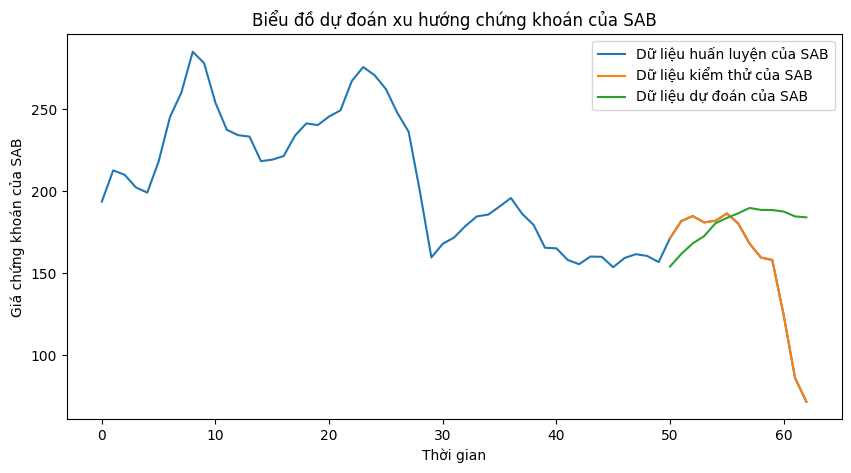

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(sab_total, label="Dữ liệu huấn luyện của %s" % stock_symbols[9])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[9])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[9])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[9])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[9])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.69


#The End
